In [13]:
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [16]:
# --- CONFIGURATION ---
OUTPUT_DIR = "output"
OUTPUT_FILE = "nyc_census_tract_demographics.csv"

# ACS variable codes for Total Population and Median Household Income
ACS_VARS = {
    "B01003_001E": "total_population",
    "B19013_001E": "median_income"
}

In [17]:
# ---CONSTRUCT AND EXECUTE CENSUS API CALL ---
print("Requesting data from the US Census API...")

# Construct the API URL to get the variables for all tracts in New York State (FIPS code 36)
var_string = ",".join(ACS_VARS.keys())
api_url = f"https://api.census.gov/data/2022/acs/acs5?get={var_string},NAME&for=tract:*&in=state:36"

# Make the request and convert the JSON response to a DataFrame
response = requests.get(api_url)
data = response.json()
df_acs = pd.DataFrame(data[1:], columns=data[0])

print(f"Data for {len(df_acs)} tracts in NY State loaded successfully.")

Requesting data from the US Census API...
Data for 5411 tracts in NY State loaded successfully.


In [18]:
# ---FILTER TO NYC BOROUGHS ---
print("\nFiltering data to the five NYC boroughs...")

# FIPS codes for the 5 NYC counties
nyc_county_fips = ['005', '047', '061', '081', '085'] # Bronx, Kings, New York, Queens, Richmond
df_acs_nyc = df_acs[df_acs['county'].isin(nyc_county_fips)].copy()

print(f"Data filtered to NYC-only tracts: {len(df_acs_nyc)} remaining.")


Filtering data to the five NYC boroughs...
Data filtered to NYC-only tracts: 2327 remaining.


In [19]:
# ---CLEAN DATA AND FORMAT TRACT IDS ---
print("\nCleaning data and creating custom tract IDs...")

# Rename the columns to be more descriptive
df_acs_nyc = df_acs_nyc.rename(columns=ACS_VARS)

# Define the mapping from county FIPS to our custom borough digit
county_to_borough_digit = {
    '061': '1',  # Manhattan (New York County)
    '005': '2',  # Bronx
    '047': '3',  # Brooklyn (Kings County)
    '081': '4',  # Queens
    '085': '5'   # Staten Island (Richmond County)
}

# Create the custom 7-digit tract ID to match your other files
df_acs_nyc['tract_id'] = df_acs_nyc['county'].map(county_to_borough_digit) + df_acs_nyc['tract']
print("Custom tract IDs created.")

# Convert population and income to numeric types.
# The API returns negative values for missing/suppressed data, so we'll turn those into NaN (Not a Number).
for col in ['total_population', 'median_income']:
    df_acs_nyc[col] = pd.to_numeric(df_acs_nyc[col], errors='coerce')
    df_acs_nyc.loc[df_acs_nyc[col] < 0, col] = None # Set negative values to NaN

# Keep only the essential, final columns
df_final = df_acs_nyc[['tract_id', 'total_population', 'median_income']]
print("Data cleaned and formatted.")


Cleaning data and creating custom tract IDs...
Custom tract IDs created.
Data cleaned and formatted.


In [20]:
# --- SAVE THE FINAL CSV ---
print("\nSaving the final demographic data CSV...")
os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILE)
df_final.to_csv(output_path, index=False)

print(f"Final demographics file saved to: '{output_path}'")
print("\n--- Sample of the Final Demographics Data ---")
print(df_final.head())


Saving the final demographic data CSV...
Final demographics file saved to: 'output/nyc_census_tract_demographics.csv'

--- Sample of the Final Demographics Data ---
    tract_id  total_population  median_income
101  2000100            4446.0            NaN
102  2000200            4870.0       115064.0
103  2000400            6257.0       100553.0
104  2001600            6177.0        41362.0
105  2001901            2181.0        49500.0


In [9]:
# ACS Data
acs = df_final.copy()

# Basic info
print("Shape:", acs.shape)
print("\nData Types:")
print(acs.dtypes)

# Null and missing data analysis
print("\n Missing Data Overview:")
missing_summary = acs.isnull().sum().sort_values(ascending=False)
missing_percent = (acs.isnull().mean() * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({"Missing Count": missing_summary, "Missing %": missing_percent})
display(missing_df.head(15))

# Quick numeric stats
acs.describe(include='all').T.head(10)

Shape: (2327, 3)

Data Types:
tract_id             object
total_population    float64
median_income       float64
dtype: object

 Missing Data Overview:


,Missing Count,Missing %
median_income,126,5.414697
tract_id,0,0.000000
total_population,0,0.000000


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tract_id,2327,2327,5990100,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_population,2327.0,NaN,NaN,NaN,3705.400516,2061.952453,0.0,2293.0,3445.0,4873.0,15945.0
median_income,2201.0,NaN,NaN,NaN,85195.831895,41342.317713,11406.0,57340.0,78750.0,103673.0,250001.0


In [10]:
# Replace zeros and negative values with NaN for key metrics
acs["median_income"] = acs["median_income"].mask(acs["median_income"] <= 0)
acs["total_population"] = acs["total_population"].mask(acs["total_population"] <= 0)

# Impute missing values with borough or citywide median
acs["median_income"] = acs["median_income"].fillna(acs["median_income"].median())
acs["total_population"] = acs["total_population"].fillna(acs["total_population"].median())

# Check categorical or geographic identifiers
acs["tract_id"] = acs["tract_id"].astype(str).str.zfill(7)
print("Cleaned ACS dataframe.")


Cleaned ACS dataframe.


In [21]:
acs["income_weight"] = 1 / acs["median_income"]
acs["income_weight"] = (acs["income_weight"] - acs["income_weight"].min()) / \
                       (acs["income_weight"].max() - acs["income_weight"].min())
acs["income_weight"] = 0.5 + acs["income_weight"] * 1.5  # Scale between 0.5–2.0

acs["pop_weight"] = acs["total_population"] / acs["total_population"].max()

# Combine into one equity weight vector
acs["equity_weight"] = 0.5 * acs["income_weight"] + 0.5 * acs["pop_weight"]

# Save cleaned ACS data
acs.to_csv("output/ACS_cleaned_equity.csv", index=False)
print("Saved cleaned and weighted ACS dataset.")

Saved cleaned and weighted ACS dataset.


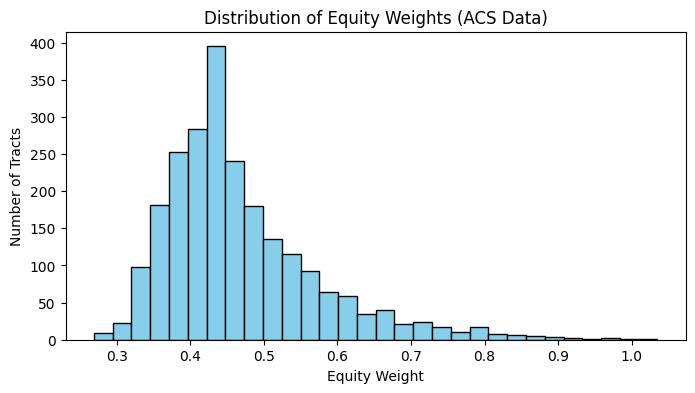

In [23]:
plt.figure(figsize=(8,4))
plt.hist(acs["equity_weight"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Equity Weights (ACS Data)")
plt.xlabel("Equity Weight")
plt.ylabel("Number of Tracts")
plt.show()
